In [3]:
import h5py    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from tsfresh.feature_extraction import feature_calculators as fc
from tqdm import tqdm
from sklearn.decomposition import FastICA, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.constraints import max_norm

# I. Explorer les données

On commence par visualiser la data du challenge.

In [ ]:
# loads the data
train_file_signal = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/X_train.h5"
train_file_labels = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/y_train.csv"
signal_dataset = h5py.File(train_file_signal,'r+')    
labels_dataset = pd.read_csv(train_file_labels)     

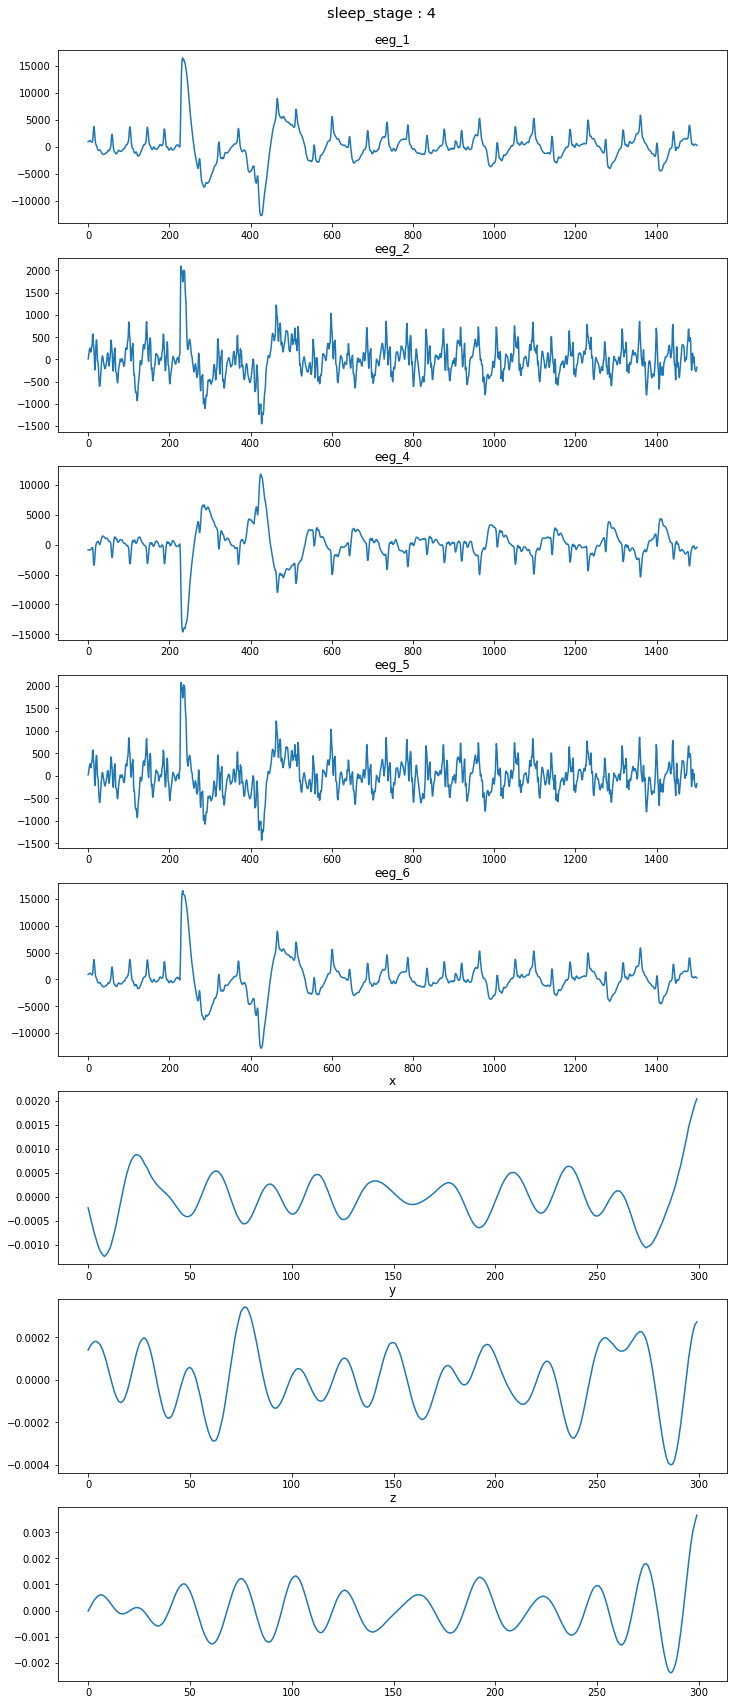

In [ ]:
# displays the signals of a random window

indice = np.random.randint(15000)
signals_names = list(signal_dataset.keys())
signals_names.remove("index")
fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(12, 30))
st = fig.suptitle("sleep_stage : " + str(labels_dataset.loc[indice, "sleep_stage"]), fontsize="x-large")
i = 0
for key in signals_names : 
    ax[i].plot(signal_dataset[key][indice])
    ax[i].set_title(key) 
    i = i + 1

st.set_y(0.90)
fig.subplots_adjust(top=0.88)


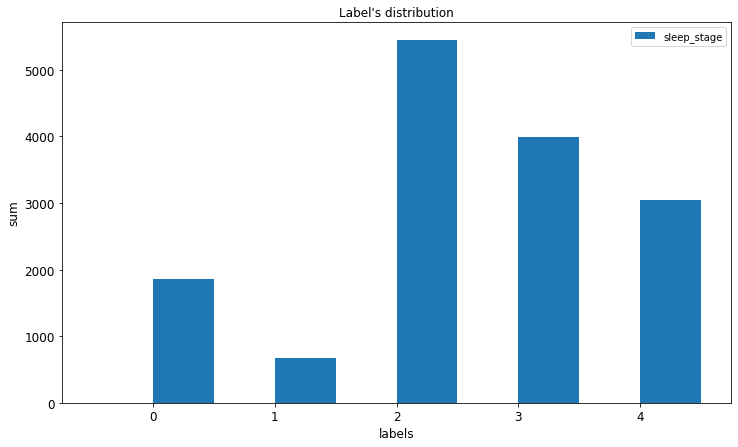

In [ ]:
# displays the proportion of each label

ax = labels_dataset[["sleep_stage"]].plot(kind='hist', title ="Label's distribution",range = [-0.5, 4.5], figsize=(12, 7), fontsize=12)
ax.set_xlabel("labels", fontsize=12)
ax.set_ylabel("sum", fontsize=12)
plt.show()

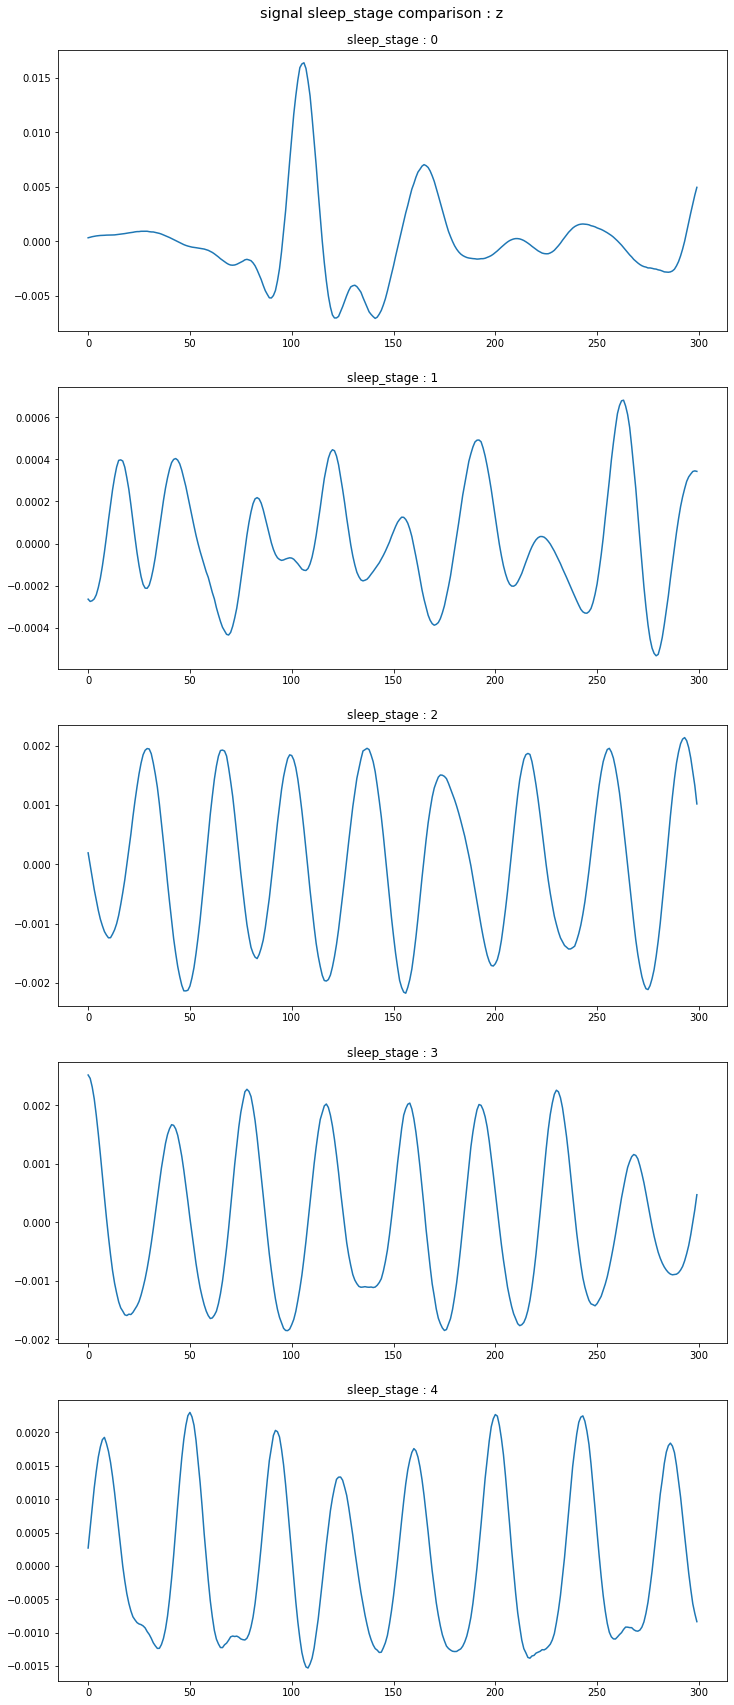

In [ ]:
# display signal exemple for each labels
# names signals ['eeg_1', 'eeg_2', 'eeg_4', 'eeg_5', 'eeg_6', 'x', 'y', 'z']

key = "z"
indices = []
for i in range(5):
    indices.append(int(labels_dataset.loc[labels_dataset["sleep_stage"] == i].sample()['index']))
    
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 30))
st = fig.suptitle("signal sleep_stage comparison : " + key, fontsize="x-large")
i = 0
for indice in indices : 
    ax[i].plot(signal_dataset[key][indice])
    ax[i].set_title("sleep_stage : " + str(i)) 
    i = i + 1

st.set_y(0.90)
fig.subplots_adjust(top=0.88)   

# II. Extraction des features

Dans cette partie, la data est prétraitée et les features sont extraites.

Il existe 5 types d’ondes (delta, thêta, alpha, bêta et gamma) détectées par l’EEG. Ces ondes caractérisent les états de sommeil :
- éveil : ondes alpha et bêta.
- N1 : ondes thêta.
- N2 : ondes thêta.
- N3 : ondes delta.
- REM : aucune des ondes précédentes.

On utilisera des filtres Butterworth pour extraire ces ondes:
- Ondes delta : filtre passe-bas d’ordre 5 à une pulsation de 4/25.
- Ondes thêta : filtre passe-bande entre 4 Hz et 8 Hz.
- Ondes alpha : filtre passe-bande entre 8 Hz et 13 Hz.
- Ondes bêta : filtre passe-bande entre 13 Hz et 22 Hz.
- Ondes gamma : filtre passe-haut de pulsation 0.5 et d’ordre 5.

In [ ]:
def normaliz_signal(signal):
    # signal normalization 
    max_signal=np.max(np.abs(signal))
    return(signal/max_signal)
def butter_bandpass(lowcut, highcut,fs=50, order=5):
    # uses Butterworth filter to filter the signal
    nyq = 0.5*fs # Fréquence de Nyquist
    low = lowcut/nyq
    high = highcut/nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a
def apply_filters(x):
#delta waves  
    b, a = butter(N=5, Wn=4/25, btype ='lowpass')
    delta = lfilter(b, a, x)
#theta waves
    b, a = butter_bandpass(4,8)
    theta = lfilter(b,a,x)
#alpha waves
    b, a= butter_bandpass(8,13)
    alpha = lfilter(b,a,x)
#beta waves
    b, a = butter_bandpass(13,22)
    beta = lfilter(b,a,x)
#gamma waves
    b, a = butter(N=5, Wn=1/2 , btype="highpass")
    gamma = lfilter(b,a,x)
    return delta, theta, alpha, beta, gamma

# Features extraction : 12 features
def abs_energy(x):
    return fc.abs_energy(x)
def kurtosis(x):
    return fc.kurtosis(x)
def mean(x):
    return fc.mean(x)
def median(x):
    return fc.median(x)
def first_quantile(x):
    return fc.quantile(x,1/4)
def third_quantile(x):
    return fc.quantile(x,3/4)
def sample_entropy(x):
    return fc.sample_entropy(x)
def skewness(x):
    return fc.skewness(x)
def variance(x):
    return fc.variance(x)
def DMM(x):
    lambda_ = len(x)//10
    d = 0
    for i in range(10):
        xmin = np.argmin(x[lambda_*i: lambda_*(i+1)])
        xmax = np.argmax(x[lambda_*i: lambda_*(i+1)])
        ymin = np.min(x[lambda_*i: lambda_*(i+1)])
        ymax = np.max(x[lambda_*i: lambda_*(i+1)])
        d += ((xmax-xmin)**2+(ymax-ymin)**2)**0.5
    return d
def Esis(X,v):
    return(np.sum([X[i]**2 for i in range(len(X))])*v)
def IQR(x):
    return first_quantile(x)-third_quantile(x)
def mode(x):
    unique, counts = np.unique(x, return_counts=True)
    return unique[np.argmax(counts)]


In [ ]:
def Spectrofiltre(signal, Scaled = True, Fs = 60):

    delta, theta, alpha, beta, gamma = apply_filters(signal)
    if (Scaled == True):

        plt.subplot(6,1,1)
        array = plt.magnitude_spectrum(signal,Fs)
        plt.ylabel('signal')
        ax=plt.gca()
        ax.set_ylim([0, np.max(array[0]) ])
        plt.subplot(6,1,2)
        plt.magnitude_spectrum(delta,Fs)
        plt.ylabel('delta')
        ax=plt.gca()
        ax.set_ylim([0, np.max(array[0]) ])
        plt.subplot(6,1,3)
        plt.magnitude_spectrum(theta,Fs)
        plt.ylabel('theta')
        ax=plt.gca()
        ax.set_ylim([0, np.max(array[0]) ])
        plt.subplot(6,1,4)
        plt.magnitude_spectrum(alpha,Fs)
        plt.ylabel('alpha')
        ax=plt.gca()
        ax.set_ylim([0, np.max(array[0]) ])
        plt.subplot(6,1,5)
        plt.magnitude_spectrum(beta,Fs)
        plt.ylabel('beta')
        ax=plt.gca()
        ax.set_ylim([0, np.max(array[0]) ])
        plt.subplot(6,1,6)
        plt.magnitude_spectrum(gamma,Fs)
        plt.ylabel('gamma')
        ax=plt.gca()
        ax.set_ylim([0, np.max(array[0]) ])
        ax=plt.gca()

        plt.show()

    elif (Scaled == False):

        plt.subplot(6,1,1)
        array = plt.magnitude_spectrum(signal,Fs)
        plt.ylabel('signal')
        plt.subplot(6,1,2)
        plt.magnitude_spectrum(delta,Fs)
        plt.ylabel('delta')
        plt.subplot(6,1,3)
        plt.magnitude_spectrum(theta,Fs)
        plt.ylabel('theta')
        plt.subplot(6,1,4)
        plt.magnitude_spectrum(alpha,Fs)
        plt.ylabel('alpha')
        plt.subplot(6,1,5)
        plt.magnitude_spectrum(beta,Fs)
        plt.ylabel('beta')
        plt.subplot(6,1,6)
        plt.magnitude_spectrum(gamma,Fs)
        plt.ylabel('gamma')
        ax=plt.gca()

        plt.show()
        


In [ ]:
#pipeline
def data_processing(X):
    features = []
    for i in tqdm(range(len(X["eeg_1"]))):
        Subject=[]
        ID = X['index'][i]
        Absolute = X['index'][i]
        Subject.append(ID)
        Subject.append(Absolute)

     # Features of eeg signals

        for j in [1,2,4,5,6]:
            sign = "eeg_"+str(j)
            signal_j = X[sign][i]
            delta_j, theta_j, alpha_j, beta_j, gamma_j = apply_filters(signal_j)
            Subject = Subject + [DMM(delta_j) , DMM(theta_j) , DMM(alpha_j), DMM(beta_j) , DMM(gamma_j) ]
            Subject = Subject + [Esis(delta_j,2*len(delta_j)//10),Esis(theta_j,6*len(theta_j)//10),Esis(alpha_j,10.5*len(alpha_j)//10),Esis(beta_j,17.5*len(beta_j)//10),Esis(gamma_j,30*len(gamma_j)//10)]
            Subject = Subject + [ mean(delta_j) , mean(theta_j) , mean(alpha_j) , mean(beta_j) , mean(gamma_j) ]
            Subject = Subject + [ variance(delta_j) , variance(theta_j) , variance(alpha_j) , variance(beta_j) , variance(gamma_j) ]
            Subject = Subject + [ kurtosis(delta_j) , kurtosis(theta_j) , kurtosis(alpha_j) , kurtosis(beta_j) , kurtosis(gamma_j) ]
            Subject = Subject + [ skewness(delta_j) , skewness(theta_j) , skewness(alpha_j) , skewness(beta_j) , skewness(gamma_j) ]
            Subject = Subject + [ abs_energy(delta_j) , abs_energy(theta_j), abs_energy(alpha_j) , abs_energy(beta_j) , abs_energy(gamma_j) ]
            Subject = Subject + [ first_quantile(delta_j) , first_quantile(theta_j) , first_quantile(alpha_j) , first_quantile(beta_j) , first_quantile(gamma_j) ]
            Subject = Subject + [ median(delta_j) , median(theta_j) , median(alpha_j) , median(beta_j) , median(gamma_j) ]
            Subject = Subject + [ third_quantile(delta_j) , third_quantile(theta_j) , third_quantile(alpha_j) , third_quantile(beta_j) , third_quantile(gamma_j) ]
            Subject = Subject + [ IQR(delta_j) , IQR(theta_j) , IQR(alpha_j) , IQR(beta_j) , IQR(gamma_j) ]
            Subject = Subject + [ mode(delta_j) , mode(theta_j) , mode(alpha_j) , mode(beta_j) , mode(gamma_j) ]

# extracting features from accelerometer data
        features_restante = ['x','y','z']

        for f in features_restante:
            signal = X[f][i]
            Subject = Subject + [ mean(signal),variance(signal),kurtosis(signal),skewness(signal),abs_energy(signal),first_quantile(signal),median(signal),third_quantile(signal),IQR(signal),mode(signal)]
        features.append(Subject)

    features=np.array(features)

    Features_List = ["DMM","Esis","Mean","Variance","Kurtosis","Skewness","Abs_energy","First_quantile","Median","Third_quantile","IQR","Mode"]
    SIGNALS = ["eeg","x","y","z"]
    column_names = ["Subject","index"]
    for string in SIGNALS :

        if(string == "eeg"):
            for i in [1,2,4,5,6]:
                for feature_str in Features_List:
                    column_names = column_names + [ string+'_'+str(i)+'_'+"Delta"+'_'+feature_str,string+'_'+str(i)+'_'+"Theta"+'_'+feature_str,string+'_'+str(i)+'_'+"Alpha"+'_'+feature_str,string+'_'+str(i)+'_'+"Beta"+'_'+feature_str,string+'_'+str(i)+'_'+"Gamma"+'_'+feature_str]
        else:
            for feature_str in Features_List[2:]:
                column_names = column_names + [string+'_'+ feature_str]

    return features, column_names

In [ ]:
file_signal = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/X_test.h5"
signal_dataset = h5py.File(file_signal,'r+')   

In [ ]:
delta, theta, alpha, beta, gamma = apply_filters(signal_dataset["eeg_1"][0])
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 7))

ax[0].plot(signal_dataset["eeg_1"][0])
ax[0].set_title("signal") 
ax[1].plot(delta)
ax[1].set_title("filtre") 


In [ ]:
Spectrofiltre(signal_dataset["eeg_1"][0])

In [ ]:
result = data_processing(signal_dataset)
file_name = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/features_test_1.csv"
dataframe = pd.DataFrame(result[0], columns = result[1])
dataframe.to_csv(file_name,index=False)

# III. Réduction de dimensions 

On essaye les deux méthodes, Analyse des Composantes Principales PCA et ExtraTreesClassifier, pour réduire la dimension lors de l'extraction des features. On utilise par la suite ExtraTreesClassifier qui garantit un meilleur score par rapport au PCA.

In [ ]:
#Data dimension reduction with PCA method

def Extractfeatures(n_estimators,datatrain):
    all_features = datatrain.keys()[2:]
    pca = PCA(n_components = n_estimators)
    scaler.fit(datatrain[all_features])
    scaler.transform(datatrain[all_features])
    datatrain[all_features] = scaler.transform(datatrain[all_features])
    pca.fit(datatrain[all_features])
    sample_features = pca.fit_transform(datatrain[all_features])
    dataframetrain_new = pd.DataFrame(sample_features)
    dataframetrain_new.insert(loc=0, column="index", value=datatrain["index"])
    dataframetrain_new.insert(loc=0, column="Subject", value=datatrain["Subject"])
    return(dataframetrain_new, pca)

In [ ]:
#Data dimension reduction with ExtraTreesClassifier method

def Extractfeatures(n_estimators,datatrain,Y):
    all_features = datatrain.keys()[2:]
    clf = ExtraTreesClassifier(n_estimators)
    clf = clf.fit(datatrain[all_features], Y["sleep_stage"])
    model0 = SelectFromModel(clf, prefit=True)
    sample_features = model0.transform(datatrain[all_features])
    dataframetrain_new = pd.DataFrame(sample_features)
    dataframetrain_new["Subject"] = datatrain["Subject"]
    dataframetrain_new["index"] = datatrain["index"]
    cols = dataframetrain_new.columns.tolist()
    B = cols.pop()
    A = cols.pop()
    cols = [A,B] + cols
    dataframetrain_new = dataframetrain_new[cols]
    return(dataframetrain_new, model0)

In [ ]:
file_name = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/features1.csv"
datatrain = pd.read_csv(file_name)
train_file_labels = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/y_train.csv"
labels = pd.read_csv(train_file_labels)   

dataframetrain_new, model0 = Extractfeatures(50,datatrain,labels)
# dataframetrain_new, pca = Extractfeatures(50,datatrain)


# all_features = datatrain.keys()[2:]
# scaler = StandardScaler()
# scaler.fit(datatrain[all_features])
# scaler.transform(datatrain[all_features])
# datatrain[all_features] = scaler.transform(datatrain[all_features])

# dataframetrain_new = datatrain



X_train, X_validation, y_train, y_validation = train_test_split(dataframetrain_new.drop(["Subject", "index"], axis=1), labels["sleep_stage"], 
                                                                test_size=0.2, random_state=42, shuffle="True")


# ros = RandomOverSampler(random_state=0)
# X_train, y_train = ros.fit_resample(X_train, y_train)

# IV. ML and Deep Learning Classification applied to features extracted

## Model 1 : RandomForest

In [4]:
model = RandomForestClassifier(n_estimators=150, criterion = "entropy", max_depth = 50, bootstrap = True,random_state=42)
model.fit(X_train, y_train)

In [ ]:
print("train accuracy : " + str(model.score(X_train, y_train)))
print("validation accuracy : " + str(model.score(X_validation, y_validation)))

In [ ]:
y_pred = model.predict(X_validation)

In [ ]:
plt.hist(y_pred, range = [-0.5, 4.5])
plt.title("label's distribution")
plt.xlabel("labels")

In [ ]:
print("accuracy score : "  + str(accuracy_score(y_pred, y_validation)))

print("precision_score : "  + str(precision_score(y_pred, y_validation, average='weighted')))
print("recall_score : "  + str(recall_score(y_pred, y_validation, average='weighted')))
print("f1_score : "  + str(f1_score(y_pred, y_validation, average='weighted')))

# print("precision_score : "  + str(precision_score(y_pred, y_validation, average='macro')))
# print("recall_score : "  + str(recall_score(y_pred, y_validation, average='macro')))
# print("f1_score : "  + str(f1_score(y_pred, y_validation, average='macro')))

## Model 2 : KNN

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
print("train accuracy : " + str(model.score(X_train, y_train)))
print("validation accuracy : " + str(model.score(X_validation, y_validation)))

train accuracy : 0.565
validation accuracy : 0.37733333333333335


In [ ]:
y_pred = model.predict(X_validation)

Text(0.5, 0, 'labels')

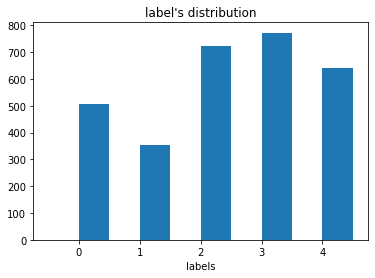

In [ ]:
plt.hist(y_pred, range = [-0.5, 4.5])
plt.title("label's distribution")
plt.xlabel("labels")

In [ ]:
print("accuracy score : "  + str(accuracy_score(y_pred, y_validation)))

print("precision_score : "  + str(precision_score(y_pred, y_validation, average='weighted')))
print("recall_score : "  + str(recall_score(y_pred, y_validation, average='weighted')))
print("f1_score : "  + str(f1_score(y_pred, y_validation, average='weighted')))

#print("precision_score : "  + str(precision_score(y_pred, y_validation, average='macro')))
#print("recall_score : "  + str(recall_score(y_pred, y_validation, average='macro')))
#print("f1_score : "  + str(f1_score(y_pred, y_validation, average='macro')))

accuracy score : 0.37933333333333336
precision_score : 0.3751612909721615
recall_score : 0.37933333333333336
f1_score : 0.36876984797745516


## Model 3 : SVM

In [ ]:
model = SGDClassifier(max_iter=10000, tol=1e-9)
model.fit(X_train, y_train)

SGDClassifier(max_iter=10000, tol=1e-09)

In [ ]:
print("train accuracy : " + str(model.score(X_train, y_train)))
print("validation accuracy : " + str(model.score(X_validation, y_validation)))

train accuracy : 0.2659166666666667
validation accuracy : 0.26366666666666666


In [ ]:
y_pred = model.predict(X_validation)

Text(0.5, 0, 'labels')

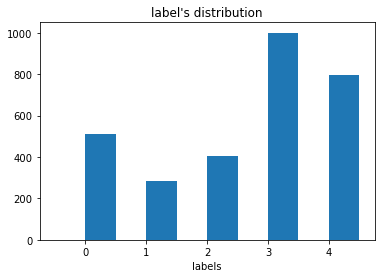

In [ ]:
plt.hist(y_pred, range = [-0.5, 4.5])
plt.title("label's distribution")
plt.xlabel("labels")

In [ ]:
print("accuracy score : "  + str(accuracy_score(y_pred, y_validation)))

print("precision_score : "  + str(precision_score(y_pred, y_validation, average='weighted')))
print("recall_score : "  + str(recall_score(y_pred, y_validation, average='weighted')))
print("f1_score : "  + str(f1_score(y_pred, y_validation, average='weighted')))

# print("precision_score : "  + str(precision_score(y_pred, y_validation, average='macro')))
# print("recall_score : "  + str(recall_score(y_pred, y_validation, average='macro')))
# print("f1_score : "  + str(f1_score(y_pred, y_validation, average='macro')))

accuracy score : 0.357
precision_score : 0.4197330366957385
recall_score : 0.357
f1_score : 0.37195807863988506


## Model 4 : NN

In [ ]:
tf.random.set_seed(42)
model = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)),
                                    tf.keras.layers.Dropout(.5),
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)),
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)),
                                    tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)),
                                    tf.keras.layers.Dense(5, activation="softmax", kernel_constraint=max_norm(3), bias_constraint=max_norm(3))])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), batch_size=16)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

750/750 [==============================] - 2s 3ms/step - loss: 824871040.0000 - accuracy: 0.2167 - val_loss: 356216800.0000 - val_accuracy: 0.2070
Epoch 2/100
750/750 [==============================] - 2s 2ms/step - loss: 501221088.0000 - accuracy: 0.1888 - val_loss: 161515792.0000 - val_accuracy: 0.1160
Epoch 3/100
750/750 [==============================] - 2s 2ms/step - loss: 182227056.0000 - accuracy: 0.2071 - val_loss: 52868164.0000 - val_accuracy: 0.1160
Epoch 4/100
750/750 [===========

KeyboardInterrupt: 

Text(0.5, 0, 'Epoch')

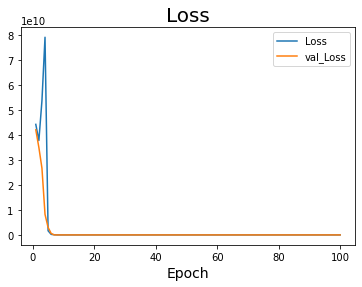

In [ ]:
plt.plot(
    np.arange(1, 101), 
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, 101), 
    history.history['val_loss'], label='val_Loss'
)
plt.legend();
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)

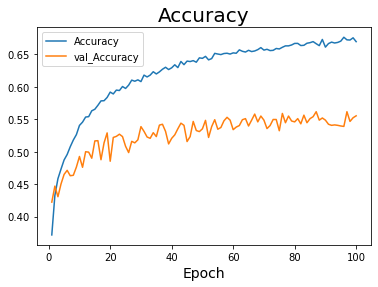

In [ ]:
plt.plot(
    np.arange(1, 101), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    np.arange(1, 101), 
    history.history['val_accuracy'], label='val_Accuracy'
)
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [ ]:
model.trainable_variables

[<tf.Variable 'dense_40/kernel:0' shape=(330, 128) dtype=float32, numpy=
 array([[-0.05250336, -0.01199783, -0.05935545, ..., -0.0906534 ,
         -0.02945854, -0.02410526],
        [-0.03051401, -0.07171462, -0.09347945, ..., -0.06673981,
         -0.0060668 , -0.042505  ],
        [-0.04051719,  0.04143707, -0.02200034, ..., -0.12571132,
         -0.07614171, -0.05942576],
        ...,
        [-0.0902641 ,  0.09134585, -0.08518618, ..., -0.10309739,
         -0.10182536, -0.02857213],
        [ 0.09340942,  0.00512318,  0.07441436, ..., -0.01414097,
          0.08717476,  0.03488904],
        [ 0.10740194, -0.03409914,  0.04579185, ...,  0.07902312,
          0.09371396,  0.00745606]], dtype=float32)>,
 <tf.Variable 'dense_40/bias:0' shape=(128,) dtype=float32, numpy=
 array([-1.26885861e-01,  6.70739450e-04, -2.49261986e-02, -2.65796930e-02,
        -6.39023557e-02, -1.22656263e-01, -4.63558026e-02, -7.79411197e-01,
        -6.27407013e-03, -1.21959383e-02, -9.69209969e-02, -2.269

In [ ]:
y_pred = tf.math.argmax(model.predict(X_validation), axis=1).numpy()

Text(0.5, 0, 'labels')

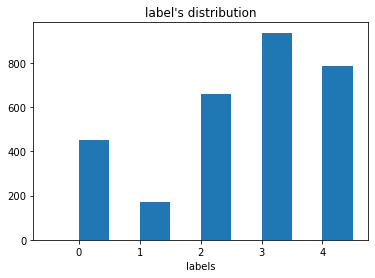

In [ ]:
plt.hist(y_pred, range = [-0.5, 4.5])
plt.title("label's distribution")
plt.xlabel("labels")

In [ ]:
print("accuracy score : "  + str(accuracy_score(y_pred, y_validation)))

print("precision_score : "  + str(precision_score(y_pred, y_validation, average='weighted')))
print("recall_score : "  + str(recall_score(y_pred, y_validation, average='weighted')))
print("f1_score : "  + str(f1_score(y_pred, y_validation, average='weighted')))

#print("precision_score : "  + str(precision_score(y_pred, y_validation, average='macro')))
#print("recall_score : "  + str(recall_score(y_pred, y_validation, average='macro')))
#print("f1_score : "  + str(f1_score(y_pred, y_validation, average='macro')))

accuracy score : 0.5553333333333333
precision_score : 0.5949123393605529
recall_score : 0.5553333333333333
f1_score : 0.5627504834539317


## Model application to test data

In [ ]:
file_name = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/features_test_1.csv"
datatest = pd.read_csv(file_name)
  

all_features = datatrain.keys()[2:]

# pca.fit(datatrain[all_features])
# sample_features = pca.fit_transform(datatestn[all_features])


sample_features = model0.transform(datatest[all_features])


dataframetest_new = pd.DataFrame(sample_features)
dataframetest_new.insert(loc=0, column="index", value=datatrain["index"])
dataframetest_new.insert(loc=0, column="Subject", value=datatrain["Subject"])

In [ ]:
# y_pred = model.predict(datatest.drop(["Subject", "index"], axis=1))


y_pred = model.predict(dataframetest_new.drop(["Subject", "index"], axis=1))

Text(0.5, 0, 'labels')

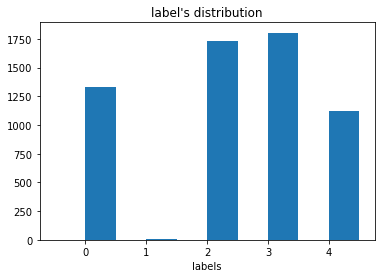

In [ ]:
plt.hist(y_pred, range = [-0.5, 4.5])
plt.title("label's distribution")
plt.xlabel("labels")

In [ ]:
result = pd.DataFrame(y_pred, index = list(datatest['index'].astype(int))) 
result.columns = ["sleep_stage"]
result.insert(loc=0, column="index", value = list(datatest['index'].astype(int)))
result = result.sort_index()

result.to_csv("C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/test_labels_5.csv", index=False)

# V. Deep Learning Classification applied to signals

In [ ]:
train_file_signal = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/X_train.h5"
train_file_labels = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/y_train.csv"
signal_dataset = h5py.File(train_file_signal,'r+')    
labels = pd.read_csv(train_file_labels)   

In [ ]:
def processing(signal_dataset):    
    features = normalize(np.concatenate((signal_dataset["eeg_1"][0][:, None],
            signal_dataset["eeg_2"][0][:, None],
            signal_dataset["eeg_4"][0][:, None],
            signal_dataset["eeg_5"][0][:, None],
            signal_dataset["eeg_6"][0][:, None], 
            np.repeat(signal_dataset["x"][0], 5)[:, None],
            np.repeat(signal_dataset["y"][0], 5)[:, None],
            np.repeat(signal_dataset["z"][0], 5)[:, None],
           ), axis = 1
    ), axis = 0)[None, :, :]

    for i in tqdm(range(0, len(signal_dataset["eeg_1"]))):


        features = np.append(features, normalize(np.concatenate((signal_dataset["eeg_1"][0][:, None],
            signal_dataset["eeg_2"][0][:, None],
            signal_dataset["eeg_4"][0][:, None],
            signal_dataset["eeg_5"][0][:, None],
            signal_dataset["eeg_6"][0][:, None], 
            np.repeat(signal_dataset["x"][0], 5)[:, None],
            np.repeat(signal_dataset["y"][0], 5)[:, None],
            np.repeat(signal_dataset["z"][0], 5)[:, None],
           ), axis = 1
    ), axis = 0)[None, :, :], axis = 0)

In [ ]:
features = normalize(np.concatenate((signal_dataset["eeg_1"][0][:, None],
        signal_dataset["eeg_2"][0][:, None],
        signal_dataset["eeg_4"][0][:, None],
        signal_dataset["eeg_5"][0][:, None],
        signal_dataset["eeg_6"][0][:, None], 
        np.repeat(signal_dataset["x"][0], 5)[:, None],
        np.repeat(signal_dataset["y"][0], 5)[:, None],
        np.repeat(signal_dataset["z"][0], 5)[:, None],
       ), axis = 1
), axis = 0)[None, :, :]

for i in tqdm(range(0, len(signal_dataset["eeg_1"]))):


    features = np.append(features, normalize(np.concatenate((signal_dataset["eeg_1"][0][:, None],
        signal_dataset["eeg_2"][0][:, None],
        signal_dataset["eeg_4"][0][:, None],
        signal_dataset["eeg_5"][0][:, None],
        signal_dataset["eeg_6"][0][:, None], 
        np.repeat(signal_dataset["x"][0], 5)[:, None],
        np.repeat(signal_dataset["y"][0], 5)[:, None],
        np.repeat(signal_dataset["z"][0], 5)[:, None],
       ), axis = 1
), axis = 0)[None, :, :], axis = 0)

 18%|█▊        | 2636/15000 [01:31<07:11, 28.67it/s]


KeyboardInterrupt: 

In [ ]:
features = processing(signal_dataset)

 32%|███▏      | 4851/15000 [05:12<10:53, 15.53it/s]


KeyboardInterrupt: 

In [ ]:
features.shape

(2637, 1500, 8)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(features, labels.loc[:2636, "sleep_stage"], 
                                                                test_size=0.2, random_state=42, shuffle="True")

# ros = RandomOverSampler(random_state=0)
# X_train, y_train = ros.fit_resample(X_train, y_train)

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", input_shape=[1500, 8]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

          
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())



model.add(tf.keras.layers.GlobalAveragePooling1D())

model.add(tf.keras.layers.Dense(5, activation="softmax"))

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=opt,
  metrics=['acc']
)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation), batch_size=32)

Epoch 1/20
66/66 [==============================] - 34s 521ms/step - loss: 1.4687 - acc: 0.3599 - val_loss: 1.3887 - val_acc: 0.4110
Epoch 2/20
66/66 [==============================] - 34s 513ms/step - loss: 1.4173 - acc: 0.3651 - val_loss: 1.3690 - val_acc: 0.4110
Epoch 3/20
66/66 [==============================] - 34s 508ms/step - loss: 1.4153 - acc: 0.3779 - val_loss: 1.3830 - val_acc: 0.4110
Epoch 4/20
66/66 [==============================] - 34s 508ms/step - loss: 1.4216 - acc: 0.3698 - val_loss: 1.3656 - val_acc: 0.4110
Epoch 5/20
66/66 [==============================] - 34s 516ms/step - loss: 1.4142 - acc: 0.3779 - val_loss: 1.3757 - val_acc: 0.4110
Epoch 6/20
66/66 [==============================] - 34s 522ms/step - loss: 1.4134 - acc: 0.3722 - val_loss: 1.3638 - val_acc: 0.4110
Epoch 7/20
66/66 [==============================] - 30s 451ms/step - loss: 1.4140 - acc: 0.3779 - val_loss: 1.3706 - val_acc: 0.4110
Epoch 8/20
66/66 [==============================] - 29s 433ms/step - 

In [ ]:
plt.plot(
    np.arange(1, 51), 
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, 51), 
    history.history['val_loss'], label='val_Loss'
)
plt.legend();
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)

In [ ]:
plt.plot(
    np.arange(1, 51), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    np.arange(1, 51), 
    history.history['val_accuracy'], label='val_Accuracy'
)
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [ ]:
y_pred = tf.math.argmax(model.predict(X_validation), axis=1).numpy()

In [ ]:
plt.hist(y_pred, range = [-0.5, 4.5])
plt.title("label's distribution")
plt.xlabel("labels")

In [ ]:
print("accuracy score : "  + str(accuracy_score(y_pred, y_validation)))

print("precision_score : "  + str(precision_score(y_pred, y_validation, average='weighted')))
print("recall_score : "  + str(recall_score(y_pred, y_validation, average='weighted')))
print("f1_score : "  + str(f1_score(y_pred, y_validation, average='weighted')))

# print("precision_score : "  + str(precision_score(y_pred, y_validation, average='macro')))
# print("recall_score : "  + str(recall_score(y_pred, y_validation, average='macro')))
# print("f1_score : "  + str(f1_score(y_pred, y_validation, average='macro')))

## Model application to test data

In [ ]:
test_file_signal = "C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/X_train.h5"
signal_dataset = h5py.File(train_file_signal,'r+')   

In [ ]:
features = processing(signal_dataset)

In [ ]:
y_pred = tf.math.argmax(model.predict(features), axis=1).numpy()

In [ ]:
result = pd.DataFrame(y_pred, index = y_validation.index) 
result.columns = ["sleep_stage"]
result.insert(loc=0, column="index", value=result.index)
result = result.sort_index()

result.to_csv("C:/Users/monta/Documents/data/dreem-3-sleep-staging-challenge-2021/test_labels.csv")